In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig
import torch
torch.manual_seed(1234)

/hpc2hdd/home/cguo847/.conda/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat", trust_remote_code=True)

In [3]:
model = AutoModelForCausalLM.from_pretrained("Qwen-VL/output_Qwen_VL_Chat", device_map="cuda", trust_remote_code=True).eval()

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Loading checkpoint shards: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


In [4]:
import re
import subprocess
import os
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

grounded_sam_directory = "/hpc2hdd/home/cguo847/Grounded-Segment-Anything"

def detect_and_segment(response, query):
    """
    检测 response 中的 <gsam></gsam> 标签，并提取其中的文本作为检测和分割的输入。
    
    :param response: 模型的响应字符串
    :param query: 查询对象，包含图像的 URL 和描述文本
    """
    def extract_image_path(query_output):
        """
        从 query 输出中提取图像路径
        """
        image_url_match = re.search(r'<img>(.*?)</img>', query_output)
        if image_url_match:
            return image_url_match.group(1)
        else:
            print("No image URL found in the query output.")
            return None

    # 提取图像路径
    image_path = extract_image_path(query)

    if not image_path:
        print("Failed to extract image path from query.")
        return
    
    # 检测 <gsam></gsam> 标签并提取其中的文本
    pattern = re.compile(r'<gsam>(.*?)</gsam>')
    matches = pattern.findall(response)

    if matches:
        text_prompt = matches[0]
        print(f"Detected text prompt: {text_prompt}")

        # 设置要执行的命令
        command = [
            "python", "grounded_sam_demo.py",
            "--config", "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
            "--grounded_checkpoint", "groundingdino_swint_ogc.pth",
            "--sam_checkpoint", "sam_vit_h_4b8939.pth",
            "--input_image", image_path,
            "--output_dir", "outputs",
            "--box_threshold", "0.3",
            "--text_threshold", "0.3",
            "--text_prompt", text_prompt,
            "--device", "cuda",
            "--show_image"
        ]

        # 切换到 Grounded-Segment-Anything 目录并运行命令
        current_directory = os.getcwd()
        os.chdir(grounded_sam_directory)
        
        try:
            result = subprocess.run(command, check=True, capture_output=True, text=True)
            print("Segmentation completed successfully.")
            output_image_path = None
            for line in result.stdout.split('\n'):
                if line.endswith('.jpg'):
                    output_image_path = line.strip()
                    break
            if output_image_path and os.path.exists(output_image_path):
                image = Image.open(output_image_path)
                plt.imshow(image)
                plt.axis('off')
                plt.show()
        except subprocess.CalledProcessError as e:
            print(f"An error occurred: {e}")
        finally:
            os.chdir(current_directory)
    else:
        print("No <gsam></gsam> tag found in the response.")

In [5]:
query = tokenizer.from_list_format([
    {'image': '/hpc2hdd/home/cguo847/train2017/000000174712.jpg'}, # Either a local path or an url
    {'text': 'Can you segement the airplane in this image?'},
])
response, history = model.chat(tokenizer, query=query, history=None)
print(response)

<gsam>airplane</gsam>


In [6]:
query

'Picture 1: <img>/hpc2hdd/home/cguo847/train2017/000000174712.jpg</img>\nCan you segement the airplane in this image?'

Detected text prompt: airplane
Segmentation completed successfully.


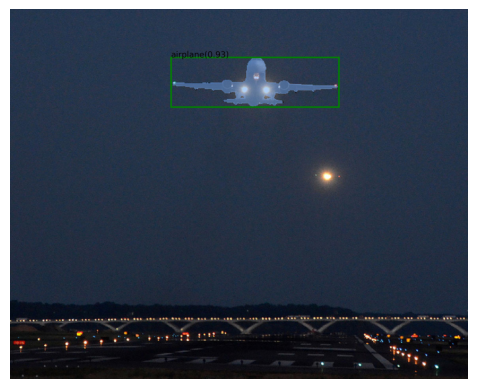

In [7]:
detect_and_segment(response, query)